### Importing the Libraries

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
tf.__version__ 

'2.15.0'

### Part 1 - Data Preprocessing

In [7]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Open the image file
    img = Image.open(image_path)

    # If the image is grayscale (1 channel), convert it to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize the image to the target size
    img = img.resize(target_size)

    # Convert to a numpy array and normalize (optional)
    #img_array = np.array(img) / 255.0  # Normalizing the image
    return img

In [11]:
#Custom data generator to preprocess images on the fly
class CustomImageDataGenerator(ImageDataGenerator):
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = []
        batch_y = []

        for i, j in enumerate(index_array):
            image_path = self.filepaths[j]
            label = self.labels[j]

            # Preprocess the image (convert grayscale to RGB)
            image = preprocess_image(image_path)
            
            batch_x.append(image)
            batch_y.append(label)

        return np.array(batch_x), np.array(batch_y)

def load_and_save_data(directory_path, target_size=(224, 224)):
    # Initialize the ImageDataGenerator for on-the-fly image preprocessing
    train_datagen = CustomImageDataGenerator(
        rescale=1./255,  # Normalize pixel values to [0, 1]
        shear_range = 0.2,
        horizontal_flip = True,
        validation_split=0.2  # 20% for validation
    )

    # Create an instance of ImageDataGenerator for testing without augmentation
    test_datagen = CustomImageDataGenerator(rescale=1./255)

    # Define the directories for the training and validation sets
    train_dir = directory_path  # Raw dataset path (directory with class subdirectories)
    test_dir = directory_path   # Assuming the test set is also in the same directory

    # Apply the data generators for training and validation
    train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',  # Change to categorical for one-hot encoding
    subset='training',
)

    validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',  # Change to categorical for one-hot encoding
    subset='validation',
)

    # Apply the test generator for evaluation
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=32,
        class_mode='categorical',  # Change to categorical for one-hot encoding
    )

    return train_generator, validation_generator, test_generator

In [12]:
# Example usage
dataset_path = "../dataset"  # Replace with your raw dataset path
train_generator, validation_generator, test_generator = load_and_save_data(dataset_path, target_size=(224, 224))

Found 3746 images belonging to 26 classes.
Found 935 images belonging to 26 classes.
Found 4681 images belonging to 26 classes.


### Part 2 - Building the CNN

In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
classifier = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(516, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax') # Assuming 26 classes for letters
])


### Part 3 - Training the CNN

#### Compiling the CNN

In [14]:
classifier.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 516)               528900    
                                                                 
 dropout_1 (Dropout)         (None, 516)               0

In [15]:
print("Output layer shape:", classifier.output_shape)

Output layer shape: (None, 26)


In [16]:
sample_data, sample_labels = next(iter(train_generator))
print("Sample data shape:", sample_data.shape)  # Expected: (batch_size, 224, 224, 3)
print("Sample labels shape:", sample_labels.shape)  # Expected: (batch_size, 26) for categorical

Sample data shape: (32, 224, 224, 3)
Sample labels shape: (32, 26)


#### Training the CNN on the Training set and validating it on the Validation set

In [17]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

# Train the model
history = classifier.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/10


118/118 [==============================] - ETA: 0s - loss: 1.4596 - accuracy: 0.5683
Epoch 1: val_loss improved from inf to 0.24775, saving model to best_model.h5


c:\Users\bhumi_umd\Desktop\Sign-Language-Recognition\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 223s 2s/step - loss: 1.4596 - accuracy: 0.5683 - val_loss: 0.2477 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 2/10
118/118 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8647
Epoch 2: val_loss improved from 0.24775 to 0.10868, saving model to best_model.h5
118/118 [==============================] - 153s 1s/step - loss: 0.4091 - accuracy: 0.8647 - val_loss: 0.1087 - val_accuracy: 0.9754 - lr: 0.0010
Epoch 3/10
118/118 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.9063
Epoch 3: val_loss improved from 0.10868 to 0.09860, saving model to best_model.h5
118/118 [==============================] - 152s 1s/step - loss: 0.2531 - accuracy: 0.9063 - val_loss: 0.0986 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 4/10
118/118 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9309
Epoch 4: val_loss improved from 0.09860 to 0.07245, saving model to best_model.h5
118/118 [======================

In [18]:
# Evaluate the model on the test data
test_loss, test_accuracy = classifier.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

147/147 [==============================] - 105s 712ms/step - loss: 0.0208 - accuracy: 0.9951
Test Loss: 0.020769979804754257
Test Accuracy: 0.9950864911079407


In [19]:
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy}")
print(f"Final Validation Accuracy: {final_validation_accuracy}")

Final Training Accuracy: 0.9687666893005371
Final Validation Accuracy: 0.9946523904800415


#### Saving the Model

In [20]:
model_json = classifier.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)
print('Model Saved')

classifier.save_weights('model_new.h5')
print('Weights saved')

Model Saved
Weights saved


### Part 4: Plotting training/validation accuracy and loss

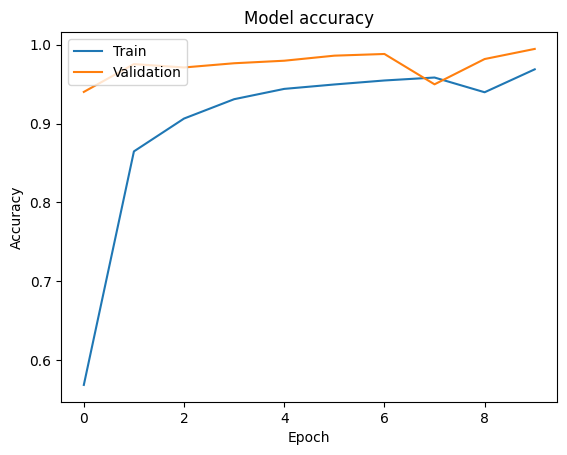

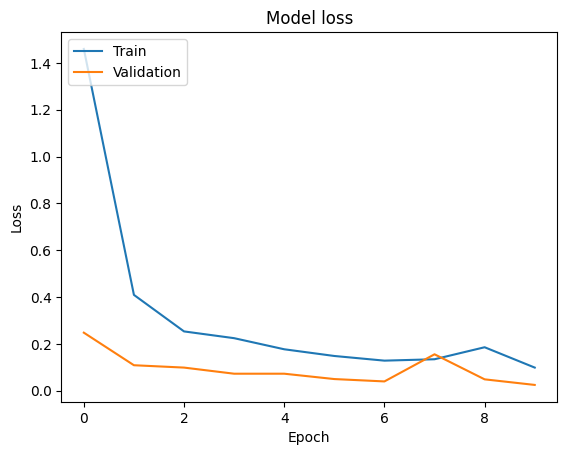

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Part 5: Evaluate model using test generator

In [22]:
y_pred = classifier.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

147/147 [==============================] - 101s 670ms/step


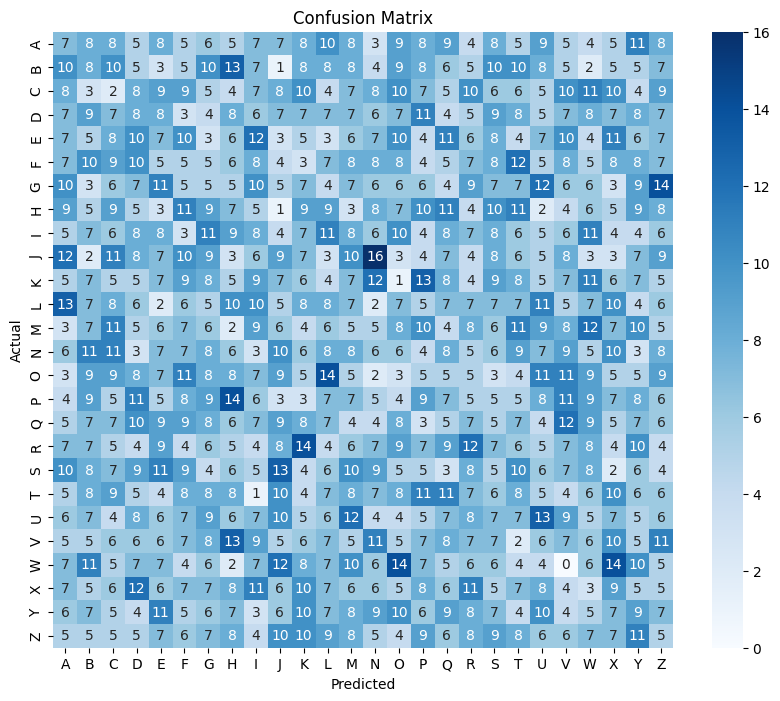

In [23]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.04      0.04      0.04       180
           1       0.04      0.04      0.04       180
           2       0.01      0.01      0.01       185
           3       0.04      0.04      0.04       180
           4       0.04      0.04      0.04       180
           5       0.03      0.03      0.03       180
           6       0.03      0.03      0.03       180
           7       0.04      0.04      0.04       180
           8       0.04      0.04      0.04       180
           9       0.05      0.05      0.05       180
          10       0.03      0.03      0.03       180
          11       0.04      0.04      0.04       180
          12       0.03      0.03      0.03       180
          13       0.03      0.03      0.03       180
          14       0.02      0.02      0.02       180
          15       0.05      0.05      0.05       180
          16       0.03      0.03      0.03       178
          17       0.07    

In [25]:
# Evaluate the model on the validation set
loss, accuracy = classifier.evaluate(validation_generator, steps=len(validation_generator))
print(f"Validation accuracy: {accuracy:.4f}")
print(f"Validation loss: {loss:.4f}")

30/30 [==============================] - 29s 959ms/step - loss: 0.0290 - accuracy: 0.9936
Validation accuracy: 0.9936
Validation loss: 0.0290
